In [1]:
from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

In [2]:
from gradient_solver import *
from collections import defaultdict

In [3]:
import os.path
from itertools import chain, combinations
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from gapstatistics.gapstatistics import GapStatistics
from clustering import AgglomerativeClusteringWrapper as AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.spatial.distance import jensenshannon, correlation, euclidean
from tqdm.contrib.concurrent import thread_map

import config

In [4]:
config.INFERENCE_MODE_EXPLAINING_FEATURES

'exact'

In [5]:
output = ClusteringApplier.calculate_explainable_distances(debug=True)

  0%|          | 0/1023 [00:00<?, ?it/s]

In [6]:
df_explainable: pd.DataFrame = ClusteringApplier.read_explaining_features() # removed [list(config.EXPLAINING_FEATURE_NAMES.keys())]
df_observable_distances: pd.DataFrame = pd.read_excel(
    f"{config.OUTPUT_FOLDER_BASE}observables/{config.DATASET_NAME}-distance-normalized-matrix-{config.DISTANCE_MEASURE_FINGERPRINT}-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",
    index_col=0
)
features: List[str] = list(config.EXPLAINING_FEATURE_NAMES.keys())

In [7]:
#df_explainable#.set_index(df_explainable.columns[0], inplace=True)
#df_observable_distances#.set_index(df_observable_distances.columns[0], inplace=True)

In [8]:
valid_indices = np.intersect1d(df_explainable.index, df_observable_distances.index)

df_explainable = df_explainable.loc[valid_indices]
df_observable_distances = df_observable_distances.loc[valid_indices]

df = df_explainable

In [9]:
def calculate_pairwise_distances_alt(
        df: pd.DataFrame, feature_names: List[str], distance: str,
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:

        if distance not in [
            "jensenshannon",
            "euclidean",
            "correlation",
        ]:
            raise Exception(
                "Invalid distance measure used to measure similarity."
            )

        distance_matrix: np.array = np.zeros((df.shape[0], df.shape[0]))

        for grp_i in range(df.shape[0]):
            for grp_j in range(df.shape[0]):      
                fingerprint_1 = df.iloc[grp_i][feature_names].to_numpy()
                fingerprint_2 = df.iloc[grp_j][feature_names].to_numpy()
                if distance == "jensenshannon":
                    dist: float = 1.0 * jensenshannon(fingerprint_1, fingerprint_2)
                elif distance == "correlation":
                    dist = 1.0 * correlation(fingerprint_1, fingerprint_2)
                else:
                    dist = 1.0 * euclidean(fingerprint_1, fingerprint_2)
                distance_matrix[grp_i, grp_j] = dist

        normalised_distance_matrix = distance_matrix / np.sum(distance_matrix)

        return pd.DataFrame(
            distance_matrix, columns=df.index, index=df.index
        ), pd.DataFrame(
            normalised_distance_matrix, columns=df.index, index=df.index, 
        )

def calculate_pairwise_distances(
            df: pd.DataFrame, feature_names: List[str], distance: str,
        ) -> Tuple[pd.DataFrame, pd.DataFrame]:

        if distance not in [
            "jensenshannon",
            "euclidean",
            "correlation",
        ]:
            raise Exception(
                "Invalid distance measure used to measure similarity."
            )

        distance_matrix: np.array = np.zeros((df.shape[0], df.shape[0]))
        arr = df.loc[:, feature_names].to_numpy()

        for grp_i in range(df.shape[0]):
            for grp_j in range(df.shape[0]):      
                fingerprint_1 = arr[grp_i]
                fingerprint_2 = arr[grp_j]
                if distance == "jensenshannon":
                    dist: float = 1.0 * jensenshannon(fingerprint_1, fingerprint_2)
                elif distance == "correlation":
                    dist = 1.0 * correlation(fingerprint_1, fingerprint_2, centered=False)
                else:
                    dist = 1.0 * euclidean(fingerprint_1, fingerprint_2)
                distance_matrix[grp_i, grp_j] = dist

        normalised_distance_matrix = distance_matrix / np.sum(distance_matrix)

        return pd.DataFrame(
            distance_matrix, columns=df.index, index=df.index
        ), pd.DataFrame(
            normalised_distance_matrix, columns=df.index, index=df.index, 
        )

def calculate_pairwise_distances_c(
            df: pd.DataFrame, feature_names: List[str], distance: str,
        ) -> Tuple[pd.DataFrame, pd.DataFrame]:

        if distance not in [
            "jensenshannon",
            "euclidean",
            "correlation",
        ]:
            raise Exception(
                "Invalid distance measure used to measure similarity."
            )

        distance_matrix: np.array = np.zeros((df.shape[0], df.shape[0]))
        arr = df.loc[:, feature_names].to_numpy()

        for grp_i in range(df.shape[0]):
            for grp_j in range(df.shape[0]):      
                fingerprint_1 = arr[grp_i]
                fingerprint_2 = arr[grp_j]
                if distance == "jensenshannon":
                    dist: float = 1.0 * jensenshannon(fingerprint_1, fingerprint_2)
                elif distance == "correlation":
                    dist = 1.0 * correlation(fingerprint_1, fingerprint_2, centered=True)
                else:
                    dist = 1.0 * euclidean(fingerprint_1, fingerprint_2)
                distance_matrix[grp_i, grp_j] = dist

        normalised_distance_matrix = distance_matrix / np.sum(distance_matrix)

        return pd.DataFrame(
            distance_matrix, columns=df.index, index=df.index
        ), pd.DataFrame(
            normalised_distance_matrix, columns=df.index, index=df.index, 
        )

def calculate_pairwise_distances2(
        df: pd.DataFrame, feature_names: List[str], distance: str,
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:

        if distance not in [
            "jensenshannon",
            "euclidean",
            "correlation",
        ]:
            raise Exception(
                "Invalid distance measure used to measure similarity."
            )

        distance_matrix: np.array = np.zeros((df.shape[0], df.shape[0]))
        fingerprint_df = df.loc[:, feature_names]
        fingerprint_array = fingerprint_df.to_numpy()

        if distance == "jensenshannon":
            dist = lambda u,v: 1.0 * jensenshannon(u,v)
        elif distance == "correlation":
            dist = lambda u,v: 1.0 * correlation(u,v, centered=False)
        else:
            dist = lambda u,v: 1.0 * euclidean(u,v) 

        for i in range(df.shape[0]):
            other_fingerprint = fingerprint_array[i]   
            distance_matrix[:, i] = np.apply_along_axis(
                 func1d=dist, axis=1, arr=fingerprint_array, v=other_fingerprint)

        normalised_distance_matrix = distance_matrix / np.sum(distance_matrix)

        return pd.DataFrame(
            distance_matrix, columns=df.index, index=df.index
        ), pd.DataFrame(
            normalised_distance_matrix, columns=df.index, index=df.index, 
        )

def numpy_matrix_correlation(A:np.array) -> np.array:

    ######################################################################################
    ### Conversion of the correlation distance from scipy.spatial.distance to pytorch. ###
    ######################################################################################

    """
    Compute the pairwise correlation distance between elements in a 2-D matrix.

    The correlation distance between two `u` and `v` in `A`, is
    defined as

    .. math::

        1 - \\frac{(u - \\bar{u}) \\cdot (v - \\bar{v})}
                  {{\\|(u - \\bar{u})\\|}_2 {\\|(v - \\bar{v})\\|}_2}

    where :math:`\\bar{u}` is the mean of the elements of `u`
    and :math:`x \\cdot y` is the dot product of :math:`x` and :math:`y`.

    Parameters
    ----------
    A : (N,M) array_like
        Input array.

    Returns
    -------
    correlation : double
        The correlation distances in 2-D array `A`.
    """
    
    AA = np.matmul(A, A.T)
    diag = np.diag(AA)
    dist = 1.0 - AA / np.sqrt(diag.reshape(-1, 1) * diag.reshape(1, -1))
    # Clip the result to avoid rounding error
    return np.clip(dist, 0.0, 2.0)

def numpy_relative_entropy(x:np.array, y:np.array) -> np.array:
    return (x * np.log(x/y))

def numpy_matrix_jensenshannon(A:np.array, epsilon:float=1e-20) -> np.array:

    ########################################################################################
    ### Conversion of the jensenshannon distance from scipy.spatial.distance to pytorch. ###
    ########################################################################################

    """
    Compute the pairwise Jensen-Shannon distance (metric) between
    all entries in a matrix. This is the square root
    of the Jensen-Shannon divergence.

    The Jensen-Shannon distance between two probability
    vectors `p` and `q` is defined as,

    .. math::

       \\sqrt{\\frac{D(p \\parallel m) + D(q \\parallel m)}{2}}

    where :math:`m` is the pointwise mean of :math:`p` and :math:`q`
    and :math:`D` is the Kullback-Leibler divergence.

    This routine will normalize `p` and `q` if they don't sum to 1.0.

    Parameters
    ----------
    A : (N,M) array_like
        matrix of probability vectors
    
    Returns
    -------
    js : double or ndarray
        The Jensen-Shannon distances along the `axis`.

    """
    
    clamped_A = A.clip(min = epsilon)
    normalized_A = clamped_A / np.expand_dims(np.sum(clamped_A, axis=1), -1)
    m_A = np.permute_dims(np.expand_dims(normalized_A, -1) + normalized_A.T, (2,0,1)) / 2.0
    relative_entropies = numpy_relative_entropy(normalized_A, m_A) + epsilon
    js = (relative_entropies.sum(axis = 2) + relative_entropies.sum(axis = 2).T).clip(min = epsilon)
    return np.sqrt(js / 2.0)

def calculate_pairwise_distances3(
        df: pd.DataFrame, feature_names: List[str], distance: str,
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:

        if distance not in [
            "jensenshannon",
            "correlation",
        ]:
            raise Exception(
                "Invalid distance measure used to measure similarity."
            )
        
        fingerprint_df = df.loc[:, feature_names]
        fingerprint_array = fingerprint_df.to_numpy()

        if distance == "jensenshannon":
            distance_matrix = numpy_matrix_jensenshannon(fingerprint_array)
        elif distance == "correlation":
            distance_matrix = numpy_matrix_correlation(fingerprint_array)
        else:
             raise Exception(f'Not Implemented: {distance}')


        normalised_distance_matrix = distance_matrix / np.sum(distance_matrix)

        return pd.DataFrame(
            distance_matrix, columns=df.index, index=df.index
        ), pd.DataFrame(
            normalised_distance_matrix, columns=df.index, index=df.index, 
        )

def calculate_pairwise_distances3c(
        df: pd.DataFrame, feature_names: List[str], distance: str,
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:

        if distance not in [
            "jensenshannon",
            "correlation",
        ]:
            raise Exception(
                "Invalid distance measure used to measure similarity."
            )
        
        fingerprint_df = df.loc[:, feature_names]
        fingerprint_array = fingerprint_df.to_numpy()
        fingerprint_array = fingerprint_array - np.mean(fingerprint_array)

        if distance == "jensenshannon":
            distance_matrix = numpy_matrix_jensenshannon(fingerprint_array)
        elif distance == "correlation":
            distance_matrix = numpy_matrix_correlation(fingerprint_array)
        else:
             raise Exception(f'Not Implemented: {distance}')

        normalised_distance_matrix = distance_matrix / np.sum(distance_matrix)

        return pd.DataFrame(
            distance_matrix, columns=df.index, index=df.index
        ), pd.DataFrame(
            normalised_distance_matrix, columns=df.index, index=df.index, 
        )

def calculate_pairwise_distances4(
        df: pd.DataFrame, feature_names: List[str], distance: str,
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:

        if distance not in [
            "jensenshannon",
            "euclidean",
            "correlation",
        ]:
            raise Exception(
                "Invalid distance measure used to measure similarity."
            )

        distance_matrix: np.array = np.zeros((df.shape[0], df.shape[0]))
        fingerprint_df = df.loc[:, feature_names]
        fingerprint_array = fingerprint_df.to_numpy()

        if distance == "jensenshannon":
            dist = lambda u,v: 1.0 * torch_jensenshannon(torch.tensor(u),torch.tensor(v)).numpy()
        elif distance == "correlation":
            dist = lambda u,v: 1.0 * torch_correlation(torch.tensor(u),torch.tensor(v), w = None, centered=False).numpy()
        else:
            dist = lambda u,v: 1.0 * euclidean(u,v) 

        for i in range(df.shape[0]):
            other_fingerprint = fingerprint_array[i]   
            distance_matrix[:, i] = np.apply_along_axis(
                 func1d=dist, axis=1, arr=fingerprint_array, v=other_fingerprint)

        normalised_distance_matrix = distance_matrix / np.sum(distance_matrix)

        return pd.DataFrame(
            distance_matrix, columns=df.index, index=df.index
        ), pd.DataFrame(
            normalised_distance_matrix, columns=df.index, index=df.index, 
        )

In [10]:
sparsity_parameter = 0.05
distance_measure = 'correlation'

powerset_features = chain.from_iterable(
    combinations(features, r) for r in range(2, len(features) + 1)
)
powerset_method_input = [
    [
        list(feature_set), df_explainable, df_observable_distances, sparsity_parameter, distance_measure]
    for feature_set in powerset_features
]

dummy_input = powerset_method_input[-1]
input_df = dummy_input[1]
input_feature_names = dummy_input[0]
input_distance = dummy_input[4]

In [11]:
fingerprint_df = df.loc[:, input_feature_names]
fingerprint_array = fingerprint_df.to_numpy()

In [12]:
input_distance = 'correlation' # 'jensenshannon'

In [13]:
ca, cb = calculate_pairwise_distances_c(input_df, input_feature_names, input_distance)
a3c, b3c = calculate_pairwise_distances3c(input_df, input_feature_names, input_distance)

In [14]:
a, b = calculate_pairwise_distances(input_df, input_feature_names, input_distance)
a2, b2 = calculate_pairwise_distances2(input_df, input_feature_names, input_distance)
a3, b3 = calculate_pairwise_distances3(input_df, input_feature_names, input_distance)
a4, b4 = calculate_pairwise_distances4(input_df, input_feature_names, input_distance)

In [15]:
np.isclose(a, a2).all().all(), np.isclose(b, b2).all().all()

(np.True_, np.True_)

In [16]:
np.isclose(a, a3).all().all(), np.isclose(b, b3).all().all()

(np.True_, np.True_)

In [17]:
np.isclose(a, a4).all().all(), np.isclose(b, b4).all().all()

(np.True_, np.True_)

In [18]:
np.isclose(a3, a4).all().all(), np.isclose(b3, b4).all().all()

(np.True_, np.True_)

In [19]:
%timeit calculate_pairwise_distances_alt(input_df, input_feature_names, input_distance)

1.38 s ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%timeit calculate_pairwise_distances(input_df, input_feature_names, input_distance)

34.9 ms ± 520 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%timeit calculate_pairwise_distances2(input_df, input_feature_names, input_distance)

39.6 ms ± 263 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%timeit calculate_pairwise_distances3(input_df, input_feature_names, input_distance)

145 µs ± 806 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [23]:
correlation_coefficients: List[float] = thread_map(
    ClusteringApplier._get_correlation_coefficient,
    powerset_method_input,
    max_workers=config.MAX_NUM_THREADS,
)

  0%|          | 0/1013 [00:00<?, ?it/s]

In [24]:
maximum_correlation: float = max(correlation_coefficients)
optimal_feature_set: List[str] = features
current_feature_size = len(features)

for index in range(len(correlation_coefficients)):
    if correlation_coefficients[index] == maximum_correlation:
        current_feature_set = powerset_method_input[index][0]
        if len(current_feature_set) < current_feature_size:
            current_feature_size = len(current_feature_set)
            optimal_feature_set = current_feature_set

<Axes: ylabel='Count'>

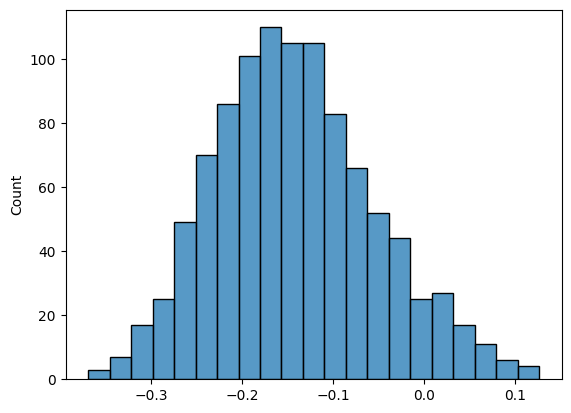

In [25]:
sns.histplot(correlation_coefficients)

In [26]:
##############
# Heuristics #
##############


In [27]:
subset_powerset_features = chain.from_iterable(
    combinations(features, r) for r in [1, 2]
)
subset_powerset_method_input = [
    [
        list(feature_set), df_explainable, df_observable_distances, sparsity_parameter, distance_measure]
    for feature_set in subset_powerset_features
]
subset_correlation_coefficients: List[float] = thread_map(
    ClusteringApplier._get_correlation_coefficient,
    subset_powerset_method_input,
    max_workers=config.MAX_NUM_THREADS,
)

  0%|          | 0/55 [00:00<?, ?it/s]

In [28]:
base_feature_importances = defaultdict(lambda: [])
for i in range(len(features)):
    feature = subset_powerset_method_input[i][0][0]
    base_value = subset_correlation_coefficients[i]
    base_feature_importances[feature].append(base_value)

base_df = pd.DataFrame(base_feature_importances)
base_df

,Age,Sex,Zoo,Stable,Genus_ID,Family_ID,Order_ID,SH,Weight,Habitat
0,-0.044499,0.002019,-0.035663,-0.033239,-0.037847,-0.029675,0.027552,-0.034349,-0.043374,-0.029315


In [29]:
cross_importance_df = pd.DataFrame(index = features, columns= features)

for j in range(len(features), len(subset_powerset_method_input)):
    feature_subset = subset_powerset_method_input[j][0]
    importance = subset_correlation_coefficients[j]
    sum_of_parts = sum([base_feature_importances[f][0] for f in feature_subset])
    cross_importance_df.loc[feature_subset[0], feature_subset[1]] = importance#(importance - sum_of_parts)
    cross_importance_df.loc[feature_subset[1], feature_subset[0]] = importance#(importance - sum_of_parts)

cross_importance_df

,Age,Sex,Zoo,Stable,Genus_ID,Family_ID,Order_ID,SH,Weight,Habitat
Age,NaN,-0.049144,-0.01129,-0.055697,0.126567,0.095875,-0.004418,-0.069433,-0.035587,0.020661
Sex,-0.049144,NaN,-0.066739,-0.094142,-0.002052,-0.041302,-0.079364,-0.09934,-0.09899,0.030103
Zoo,-0.01129,-0.066739,NaN,-0.092034,0.07688,0.069075,-0.055726,-0.094352,-0.082304,-0.050982
Stable,-0.055697,-0.094142,-0.092034,NaN,0.011987,-0.04639,-0.089473,-0.087516,-0.088279,-0.066134
Genus_ID,0.126567,-0.002052,0.07688,0.011987,NaN,0.107318,0.108198,0.096217,0.097401,-0.022967
Family_ID,0.095875,-0.041302,0.069075,-0.04639,0.107318,NaN,0.116079,0.070878,0.018751,-0.022648
Order_ID,-0.004418,-0.079364,-0.055726,-0.089473,0.108198,0.116079,NaN,-0.08404,-0.028205,-0.022594
SH,-0.069433,-0.09934,-0.094352,-0.087516,0.096217,0.070878,-0.08404,NaN,-0.034131,-0.056791
Weight,-0.035587,-0.09899,-0.082304,-0.088279,0.097401,0.018751,-0.028205,-0.034131,NaN,-0.028349
Habitat,0.020661,0.030103,-0.050982,-0.066134,-0.022967,-0.022648,-0.022594,-0.056791,-0.028349,NaN


In [30]:
feature_importances = defaultdict(lambda: 0.)
part_to_sum_feature_importances = defaultdict(lambda: 0.)

for j in range(len(features), len(subset_powerset_method_input)):
    feature_subset = subset_powerset_method_input[j][0]
    importance = subset_correlation_coefficients[j]
    sum_of_parts = sum([base_feature_importances[f][0] for f in feature_subset])
    part_to_sum_feature_importances[j] = (importance - sum_of_parts)
    feature_importances[j] = importance

In [31]:
human_readable_importances = {}
human_readable_part_to_sum_importances = {}
for k, v in feature_importances.items():
    name = subset_powerset_method_input[k][0]
    human_readable_importances[str(name)] = v

for k, v in part_to_sum_feature_importances.items():
    name = subset_powerset_method_input[k][0]
    human_readable_part_to_sum_importances[str(name)] = v

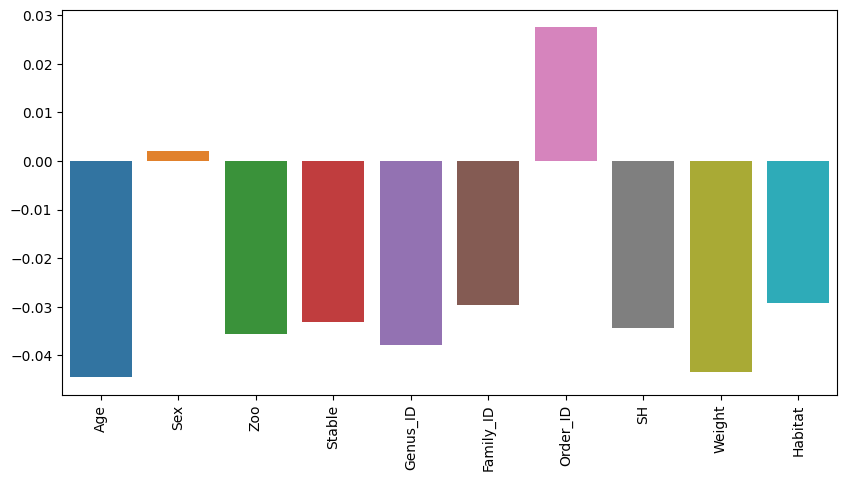

In [32]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(base_feature_importances)
ax.axes.xaxis.set_tick_params(rotation=90)

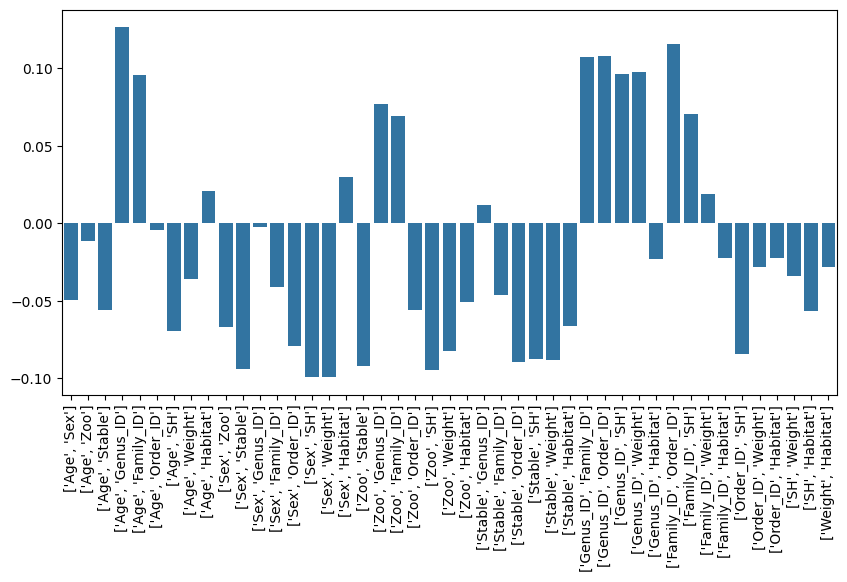

In [33]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(human_readable_importances)
ax.axes.xaxis.set_tick_params(rotation=90)

In [34]:
powerset_method_input[0][0]

['Age', 'Sex']

In [35]:
sparsity_parameter = 0.07
distance_measure = 'correlation'

powerset_features = chain.from_iterable(
    combinations(features, r) for r in range(1, len(features) + 1)
)
powerset_method_input = [
    [
        list(feature_set), df_explainable, df_observable_distances, sparsity_parameter, distance_measure]
    for feature_set in powerset_features
]
correlation_coefficients: List[float] = thread_map(
    ClusteringApplier._get_correlation_coefficient,
    powerset_method_input,
    max_workers=config.MAX_NUM_THREADS,
)

maximum_correlation: float = max(correlation_coefficients)
optimal_feature_set: List[str] = features
current_feature_size = len(features)

for index in range(len(correlation_coefficients)):
    if correlation_coefficients[index] == maximum_correlation:
        current_feature_set = powerset_method_input[index][0]
        if len(current_feature_set) < current_feature_size:
            current_feature_size = len(current_feature_set)
            optimal_feature_set = current_feature_set

  0%|          | 0/1023 [00:00<?, ?it/s]

In [41]:
N = 2

In [ ]:
# ToDo: Starting Set Idee

In [42]:
subset_powerset_features = chain.from_iterable(
    combinations(features, r) for r in [1, 2]
)
subset_powerset_method_input = [
    [
        list(feature_set), df_explainable, df_observable_distances, sparsity_parameter, distance_measure]
    for feature_set in subset_powerset_features
]
subset_correlation_coefficients: List[float] = thread_map(
    ClusteringApplier._get_correlation_coefficient,
    subset_powerset_method_input,
    max_workers=config.MAX_NUM_THREADS,
)

feature_importances = defaultdict(lambda: 0.)
part_to_sum_feature_importances = defaultdict(lambda: 0.)

for j in range(len(features), len(subset_powerset_method_input)):
    feature_subset = subset_powerset_method_input[j][0]
    importance = subset_correlation_coefficients[j]
    feature_importances[j] = importance

cross_importance_df = pd.DataFrame(index = features, columns= features)

for j in range(len(features), len(subset_powerset_method_input)):
    feature_subset = subset_powerset_method_input[j][0]
    importance = subset_correlation_coefficients[j]
    cross_importance_df.loc[feature_subset[0], feature_subset[1]] = importance
    cross_importance_df.loc[feature_subset[1], feature_subset[0]] = importance

starting_index = np.argmax(list(feature_importances.values()))
starting_pair = list(feature_importances.keys())[starting_index]
starting_features = subset_powerset_method_input[starting_pair][0]

selected_features = starting_features
print(f'Started with {starting_features}')

current_score = ClusteringApplier._get_correlation_coefficient([
    selected_features,
    df_explainable,
    df_observable_distances,
    sparsity_parameter,
    distance_measure
])

base_feature_importances = defaultdict(lambda: [])
for i in range(len(features)):
    feature = subset_powerset_method_input[i][0][0]
    base_value = subset_correlation_coefficients[i]
    base_feature_importances[feature].append(base_value)

base_df = pd.DataFrame(base_feature_importances)
best_base = base_df.T.iloc[base_df.sum(axis=0).argmax()]
best_base_feature = best_base.name
best_base_score = float(best_base.values[0])

while True:
    
    remaining_indices = cross_importance_df.loc[:, selected_features].drop(selected_features).sum(axis=1)
    if len(remaining_indices) == 0:
        break

    score_dict = {}
    for _feature in cross_importance_df.drop(selected_features).index:
        _score = ClusteringApplier._get_correlation_coefficient([
            selected_features + [_feature],
            df_explainable,
            df_observable_distances,
            sparsity_parameter,
            distance_measure
        ])
        score_dict[_score] = _feature
 
    next_score = max(score_dict.keys())
    next_feature = score_dict[next_score]

    if next_score > current_score:
        print(f"Added '{next_feature}'")
        selected_features = selected_features + [next_feature]
        current_score = next_score
    else:
        print(f"Refuted '{next_feature}'")
        break
        
if current_score <= best_base_score:
    selected_features = [best_base_feature]
    print(f'Override: Base feature performed best: {best_base_feature}')

  0%|          | 0/55 [00:00<?, ?it/s]

Started with ['Age', 'Genus_ID']
Refuted 'Family_ID'


In [43]:
sorted(optimal_feature_set)

['Age', 'Genus_ID']

In [44]:
sorted(selected_features)

['Age', 'Genus_ID']

In [45]:
...

Ellipsis

In [46]:
ClusteringApplier._feature_selection_greedy(
    df_explainable.copy(),
    df_observable_distances.copy(),
    features.copy(),
    sparsity_parameter,
    distance_measure
)

(['Order_ID', 'Family_ID'], 0.07607904072807531)

In [47]:
...

Ellipsis